# Drude's Model of Electron Flow in a Copper Wire 

In this simulation, we will model the drift speed of an electron in a copper wire. The 'copper' nuclei are arranged to imitate a face-centered cubic crystal structure in a wire of length $2L$. The model is not meant to exactly simulate electron flow at the scale of the electron and copper nuclei as well as their electromagnetic interactions. Instead, Drude's model is used to treat the electron flow as an ideal gas colliding with static 'nuclei'.

## Research Question

1. How consitent is this model when simulated in 3 dimensions?
2. Does the velocity of an electron agree with the drift speed of an electron in real life?

## Computational Model

This model uses vpython to animate the kinetic interactions of $N_e$ electrons with $N_a$ nuclei. First, the main routine will create a latice of "Copper Nuclei" that is uniform throughout the established wire. The electrons are then created and positioned randomly as to not collide with other electrons or with other nuclei. The elctrons are also given a random velocity with varying directions. A uniform electric field is imposed on this model to simulate the flow of electrons in one direction of a wire (DC). The main while loop then accounts for all collisons and redirects electron flow as needed. The instantenous x-velocity of the first electron is stored in list 'vlist' as well as the "running average" of the x-velocity in list 'vave'.

## Assumptions

1. The Drude model considers the metal to be formed of a collection of positively charged ions (copper nuclei) from which a number of "free electrons" were detached. These can be thought to be the valence electrons of the copper that have become delocalized due to the electric field.

2. All collisons are elastic collisons meaning the kinetic energy is not lost.

3. The Drude model neglects long-range interaction between the electron and the copper or between the electrons.

4. The electrons are accelerating due to the electric field; assume that electrons will reach steady state after some time.

5. The electrons move in straight lines between one collision and another.




In [1]:
from vpython import *
import numpy as np
import random as rand
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
def check_e_collisions():
    """Determine all pairs of colliding spheres in the global particles[] list. 
        
    """
    c_e_pairs = [] #a list of pairs of spheres that are overlapping
    
    for i in range(len(electrons)):
        for j in range(i+1,Ne): #start at i+1 to avoid double counting and to avoid self-collision
            d = mag(electrons[i].pos - electrons[j].pos)
            if d < 2*R:
                c_e_pairs.append([i,j])            
    
    return c_e_pairs

In [3]:
def check_a_collisions():
    """Determine all pairs of colliding spheres in the global electrons[] and atoms[] list. 
        
    """
    c_a_pairs = [] #a list of pairs of spheres that are overlapping
    
    for i in range(Ne):
        for j in range(0,len(atoms)): #start at i+1 to avoid double counting and to avoid self-collision
            d = mag(electrons[i].pos - atoms[j].pos)
            if d < R+Ra:
                c_a_pairs.append([i,j])            
    
    return c_a_pairs

In [4]:
def calc_a_collision(i,j):
    """Calculate new velocity, momentum, and position of pairs of colliding spheres in the global particles[] list. 

    Keyword arguments:
    i -- index of one colliding sphere
    j -- index of second colliding sphere

    """
    global dt
    global electrons
    global atoms
    
    r = electrons[i].pos - atoms[j].pos
    electrons[i].pos = electrons[i].pos - electrons[i].v*dt

    rhat = hat(r)
    verad = dot(electrons[i].v,rhat)*rhat #rad comp of electrons[i].v
    vetan = electrons[i].v - verad #tan comp of ball.v
    verad = - verad #reverse ball.rad due to collision
    electrons[i].v = vetan + verad #new ball.v after collision
    electrons[i].p = electrons[i].v*m
    electrons[i].pos = electrons[i].pos + electrons[i].v*dt
    
    

In [5]:
def calc_e_collision(i,j):
    """Calculate new velocity, momentum, and position of pairs of colliding spheres in the global particles[] list. 

    Keyword arguments:
    i -- index of one colliding sphere
    j -- index of second colliding sphere

    """

    global electrons

    
    r1 = electrons[i].pos
    r2 = electrons[j].pos
    v1 = electrons[i].v
    v2 = electrons[j].v
    p1 = m*v1
    p2 = m*v2
    v1i = v1
    v2i = v2
    
    #transform to reference frame of particle 1
    v2rel = v2 - v1
    r2rel = r2 - r1
 
    #find time when collision ocurred
    dxx = dot(r2rel, hat(v2rel))
    dyy = mag(cross(r2rel, hat(v2rel)))
    if(dyy>2*R): return
    alpha = asin(dyy/2/R)
    d = 2*R*cos(alpha) + dxx
    deltat = d/mag(v2rel)
    
    #move particles backward in time to their locations at the collision
    electrons[i].pos = electrons[i].pos - electrons[i].v*deltat
    electrons[j].pos = electrons[j].pos - electrons[j].v*deltat
    
    #calculate new momenta using CM reference frame
    r1 = electrons[i].pos
    r2 = electrons[j].pos
    M = 2*m #total mass
    ptot = p1+p2 #total momentum
    vcm = ptot/M
    v1rel = v1 - vcm
    v2rel = v2 - vcm
    p1rel = m*v1rel
    p2rel = m*v2rel
    r = r2 - r1
    p1rel = p1rel - 2*dot(p1rel,hat(r))*hat(r)
    p2rel = p2rel - 2*dot(p2rel,hat(r))*hat(r)
    v1rel = p1rel/m
    v2rel = p2rel/m
    v1 = vcm + v1rel
    v2 = vcm + v2rel
    p1 = m*v1
    p2 = m*v2
    electrons[i].v = v1
    electrons[j].v = v2

    electrons[i].p = electrons[i].v * m
    electrons[j].p = electrons[j].v * m
    
    #move particles forward in time to their locations at the end of the time step
    electrons[i].pos = electrons[i].pos + electrons[i].v*deltat
    electrons[j].pos = electrons[j].pos + electrons[j].v*deltat
    


In [6]:
def create_atoms():
    
    global x
    global y
    global z
    
    global dx
    global dy 
    global dz
    
    global Na
    
    global atoms
    
    
    
    for k in range(int(Na/2)):
        for i in range(Na):
            if (i==0):
                atom = sphere(pos = vec(x,y,z), radius = Ra, color = color.red)
                atoms.append(atom)
                for j in range(int(Na/2)):
                    y = y + dy
                    atom = sphere(pos = vec(x,y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                    atom = sphere(pos = vec(x,-y,z), radius = Ra, color = color.red)
                    atoms.append(atom)

                x = x + dx
                y = 0
            else:
                atom = sphere(pos = vec(x,y,z), radius = Ra, color = color.red)
                atoms.append(atom)
                for j in range(int(Na/2)):
                    y=y+dy
                    atom = sphere(pos = vec(x,y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                    atom = sphere(pos = vec(x,-y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                y = 0
                atom = sphere(pos = vec(-x,y,z), radius = Ra, color = color.red)
                atoms.append(atom)
                for j in range(int(Na/2)):
                    y=y+dy
                    atom = sphere(pos = vec(-x,y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                    atom = sphere(pos = vec(-x,-y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                x = x + dx
                y = 0
        x = 0
        y = 0
        z = z + dz
    z = -dz
    for k in range(int(Na/2)):
        for i in range(Na):
            if (i==0):
                atom = sphere(pos = vec(x,y,z), radius = Ra, color = color.red)
                atoms.append(atom)
                for j in range(int(Na/2)):
                    y = y + dy
                    atom = sphere(pos = vec(x,y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                    atom = sphere(pos = vec(x,-y,z), radius = Ra, color = color.red)
                    atoms.append(atom)

                x = x + dx
                y = 0
            else:
                atom = sphere(pos = vec(x,y,z), radius = Ra, color = color.red)
                atoms.append(atom)
                for j in range(int(Na/2)):
                    y=y+dy
                    atom = sphere(pos = vec(x,y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                    atom = sphere(pos = vec(x,-y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                y = 0
                atom = sphere(pos = vec(-x,y,z), radius = Ra, color = color.red)
                atoms.append(atom)
                for j in range(int(Na/2)):
                    y=y+dy
                    atom = sphere(pos = vec(-x,y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                    atom = sphere(pos = vec(-x,-y,z), radius = Ra, color = color.red)
                    atoms.append(atom)
                x = x + dx
                y = 0
        x = 0
        y = 0
        z = z - dz

In [11]:
scene = canvas(title="Electron flow in Cu Wire")

#constants
Ne = 20 #number of electrons
m = 9.11e-31 #mass of electron in kg
R = 2.82e-15 #radius of electron in m
Ra = 2*R
L = 40*R #length of box in m
q = -1.603e-19 #Charge of Electron
thick = L/100 #thickness of box wall in m
s = .2 # speed of electron
E = vec(-40,0,0) #Electric Field
Fnet=q*E  #Net force on electrons

dl = 1*Ra
dx = 2*Ra+dl
dy = dx
dz = dx

x=0
y=x
z=x

Na = int((L/dx)+1) #Number of Nuclei


##visual objects

Bwall = box(pos = vec(0, -L/2, 0), size = vec(2*L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(2*L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(2*L, L, thick), color=color.white)

electrons = [] #list of electrons
atoms = [] # list of atoms
vave = [] #average velocity
vlist = [] #list of instantaneous x-velocities
tlist = [] #list of time
count = 0



#create atoms
create_atoms()

#create electrons
for i in range(Ne):

    if (i==0):
        electron = sphere(pos = vec(L*rand.uniform(-0.9,0.9),L/2*rand.uniform(-0.9,0.9),L/3*rand.uniform(-0.9,0.9)), radius = R, color = color.yellow, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        electron = sphere(pos = vec(L*rand.uniform(-0.9,0.9),L/2*rand.uniform(-0.9,0.9),L/3*rand.uniform(-0.9,0.9)), radius = R, color = color.blue)

    #initial velocity
    electron.v = s*hat(vec(0,rand.uniform(-0.9,0.9),0))
    electron.p = m*electron.v

    electrons.append(electron)


#check for collisions and rerandomize positions of particles that are collided
collided_e_pairs = check_e_collisions()
collided_a_pairs = check_a_collisions()

while( len(collided_a_pairs) != 0):
    
    for pair in collided_e_pairs:
        electrons[pair[0]].pos = vec(L*rand.uniform(-0.9,0.9),L/2*rand.uniform(-0.9,0.9),L/3*rand.uniform(-0.9,0.9))
        electrons[pair[1]].pos = vec(L*rand.uniform(-0.9,0.9),L/2*rand.uniform(-0.9,0.9),L/3*rand.uniform(-0.9,0.9))
    collided_e_pairs = check_e_collisions()

    for pairA in collided_a_pairs:
        electrons[pairA[0]].pos = vec(L*rand.uniform(-0.9,0.9),L/2*rand.uniform(-0.9,0.9),L/3*rand.uniform(-0.9,0.9))
    collided_a_pairs = check_a_collisions()
    

#time
t = 0
dt = R/s/10

tlist.append(t)
vlist.append(electrons[0].v.x)
vave.append(electrons[0].v.x)



#evolution
scene.pause()
Nsteps = 1e3 #number of time steps for the loop

while t < Nsteps*dt:
    rate(2000) #sets number of loops per second in order to slow down or speed up visualization

    #update position of each particle
    for electron in electrons:
        electron.p = electron.p+Fnet*dt
        electron.v = electron.p/m
        electron.pos = electron.pos + electron.v*dt
        
    #create a looping environment so electrons appear to flow from right
    #side of wire to left side of wire
        if(electron.pos.x>L):
            electron.pos.x = -L+dl
        if(electron.pos.x<-L):
            electron.pos.x = L - dl
            
    #handle electron-electron collisions        
    collided_e_pairs = check_e_collisions()
    for pair in collided_e_pairs:
        i = pair[0]
        j = pair[1]
        calc_e_collision(i,j)
        
    #handle electron-nuclei collisions    
    collided_a_pairs = check_a_collisions()
    for pairA in collided_a_pairs:
        o = pairA[0]
        p = pairA[1]
        calc_a_collision(o,p)
        
    #handle collision with walls
    for electron in electrons:
        
        if electron.pos.y > L/2:
            electron.v.y = - abs(electron.v.y)
            electron.p = m*electron.v
        elif electron.pos.y < -L/2:
            electron.v.y = abs(electron.v.y)
            electron.p = m*electron.v

        if electron.pos.z > (L/2)-(L/8):
            electron.v.z = - abs(electron.v.z)
            electron.p = m*electron.v
        elif electron.pos.z < -L/2:
            electron.v.z = abs(electron.v.z)
            electron.p = m*electron.v
    t = dt+t 
    tlist.append(t)
    count = count + 1
    vlist.append(electrons[0].v.x)
    vave.append((vave[-1]*(count-1) + vlist[-1])/count)
   


print("DONE")          
    

<IPython.core.display.Javascript object>

DONE


## "Clean" Average x-velocity of a single electron
The instantaneous x-velocity of a single electron is plotted as a function of time. The Real-time "running average" of this velocity is also plotted underneath. This data did not contain a coding bug in which the electron becomes "stuck" within a nuclei, which begins to produce inaccurate data.

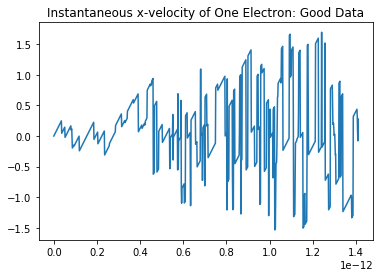

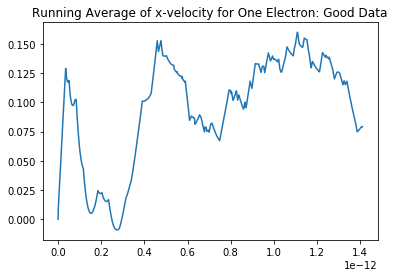

In [8]:
plt.plot(tlist, vlist)
plt.title("Instantaneous x-velocity of One Electron: Good Data")
plt.show()

plt.plot(tlist, vave)
plt.title("Running Average of x-velocity for One Electron: Good Data")
plt.show()


In [9]:
Vavetotal = sum(vlist)/len(vlist)
Vavetotal

0.07900674814262777

## 'Buggy' Average x-velocity of a single electron
This data contains a coding bug in which the electron becomes "stuck" within a nuclei, which begins to produce inaccurate data. This can be seen in the instantaneous x-velocity graph as the electron quickly oscillated between two different velocity as it is enclosed within a nucleus. This is considered bad data is it misrepresents what the Drude model is supposed to represent. 

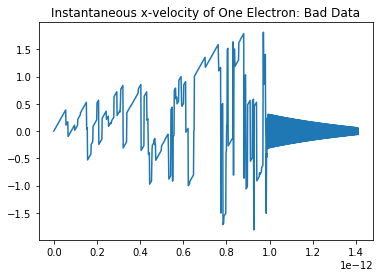

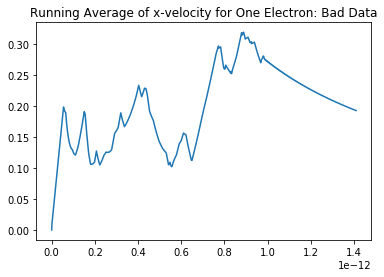

In [13]:
plt.plot(tlist, vlist)
plt.title("Instantaneous x-velocity of One Electron: Bad Data")
plt.show()

plt.plot(tlist, vave)
plt.title("Running Average of x-velocity for One Electron: Bad Data")
plt.show()


In [14]:
Vavetotal = sum(vlist)/len(vlist)
Vavetotal

0.19258267677310992

## Conclusion

This model simulated the flow of electrons given its initial conditions as well as its behavior as an ideal gas. The model provided fairly consitent results as long as the tracked electron did not get stuck within a static copper nucleus. Areas for improvement requires the calculations to be handled differently to increase computation time and reduce numerical error. A future version of this code could be implemented using less "for-loops" and instead take advantage of array manipulations/calculations using numpy. 